## Directory

In [27]:
import os

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [200]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [3]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 29s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 2.9 s, sys: 3.93 s, total: 6.82 s
Wall time: 30.3 s


## Ecoli Cellular Evolution

We record this video from [this link](https://youtu.be/TqMrzbBaQrY?si=GGG7E76FCovIi3_Q).

This short clip depicts a mutant E. coli strain that has had several proteins suppressed which control division, then Chlamydial proteins MreB and RodZ were added and they successfully led the E. coli to divide. Video provided by Anthony T. Maurelli, of the University of Florida's Emerging Pathogens Institute. Related mBio journal article with published results [here](https://journals.asm.org/doi/10.1128/mbio.03222-19).

We are not using the medical conclusion from the paper. However, we do want to grant credits to the researchers to provide us the film. We are using the film as an image data to train our model as a demoonstration that the proposed `VAPAAD` model can learn cellular evolution. Since this is unsupervised learning task, no label or any medical advice is suggested of any sort. The task is aiming to produce a model that can learn the shape and future state of cellular evolution.

In [112]:
# os.chdir('/content/')

In [113]:
import cv2
import numpy as np

def load_and_process_video(video_path, frame_size=(64, 64)):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError("Unable to open video file. Please check the file path and permissions.")

    frames = []

    while True:
        # Read each frame; ret is a boolean indicating if the operation was successful
        ret, frame = cap.read()
        if not ret:
            break  # If no frame is read (end of video or error), exit the loop

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the frame
        resized_frame = cv2.resize(gray_frame, frame_size)

        # Expand dimensions to fit the shape (64, 64, 1)
        resized_frame = np.expand_dims(resized_frame, axis=-1)

        # Append the processed frame to the list of frames
        frames.append(resized_frame)

    # Release the video capture object and close any open windows
    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames were processed. The video may be empty or corrupted.")

    # Concatenate all frames into a single numpy array
    video_array = np.stack(frames, axis=0)
    return video_array

In [135]:
%%time

# Path to your video file
video_path = '/content/ecoli.mp4'
try:
    video_frames = load_and_process_video(video_path)
    print("Shape of the video array:", video_frames.shape)
except Exception as e:
    print("An error occurred:", e)

Shape of the video array: (906, 64, 64, 1)
CPU times: user 8.32 s, sys: 4.08 s, total: 12.4 s
Wall time: 2.53 s


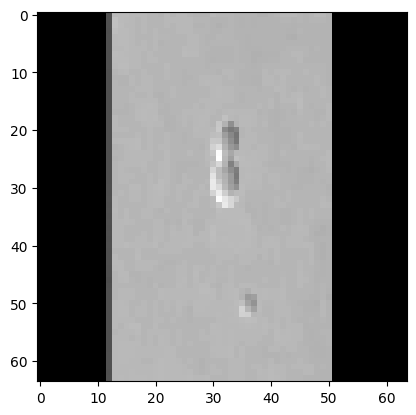

In [136]:
plt.imshow(video_frames[100], cmap='gray')

In [179]:
import numpy as np

def create_training_data(video_frames):
    num_frames = video_frames.shape[0]
    frame_sequence_length = 19
    x_train = []
    y_train = []

    # Loop through the video frames array with steps ensuring no index out of bounds
    for i in range(0, num_frames - 2 * frame_sequence_length + 1, 5):
        # Define x_train_sample and y_train_sample
        x_train_sample = video_frames[i : i + frame_sequence_length]  # Frames from i to i+18
        y_train_sample = video_frames[i + frame_sequence_length : i + 2 * frame_sequence_length]  # Frames from i+19 to i+37

        # Append samples to lists
        x_train.append(x_train_sample)
        y_train.append(y_train_sample)

    # Convert lists to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

In [180]:
%%time

# Assuming video_frames is already defined and loaded
x_train, y_train = create_training_data(video_frames)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (174, 19, 64, 64, 1)
y_train shape: (174, 19, 64, 64, 1)
CPU times: user 7.13 ms, sys: 3.99 ms, total: 11.1 ms
Wall time: 10.2 ms


In [181]:
from sklearn.model_selection import train_test_split

# Assuming x_train and y_train are already defined
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (139, 19, 64, 64, 1)
y_train shape: (139, 19, 64, 64, 1)
x_val shape: (35, 19, 64, 64, 1)
y_val shape: (35, 19, 64, 64, 1)


### Visualization

Displaying frames for example 825.


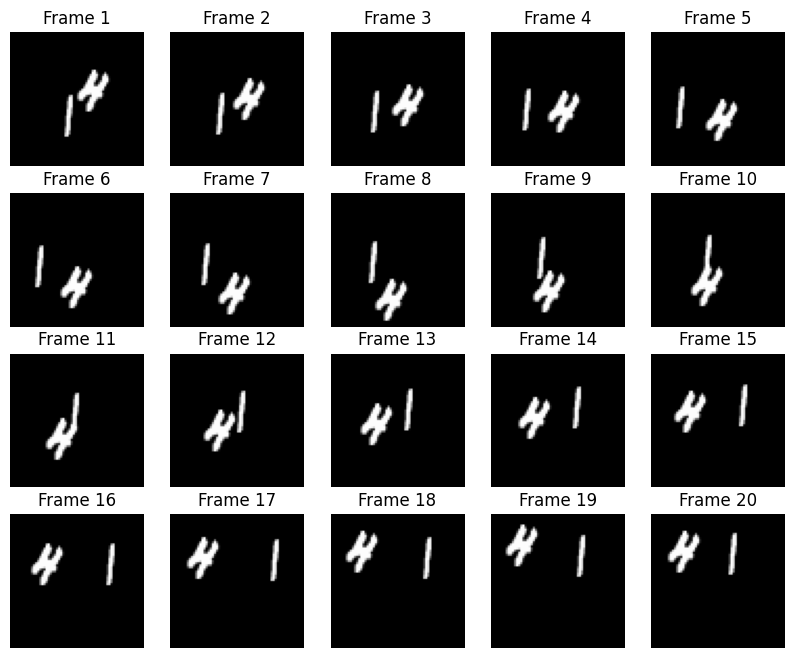

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 1.25 s


In [ ]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [106]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

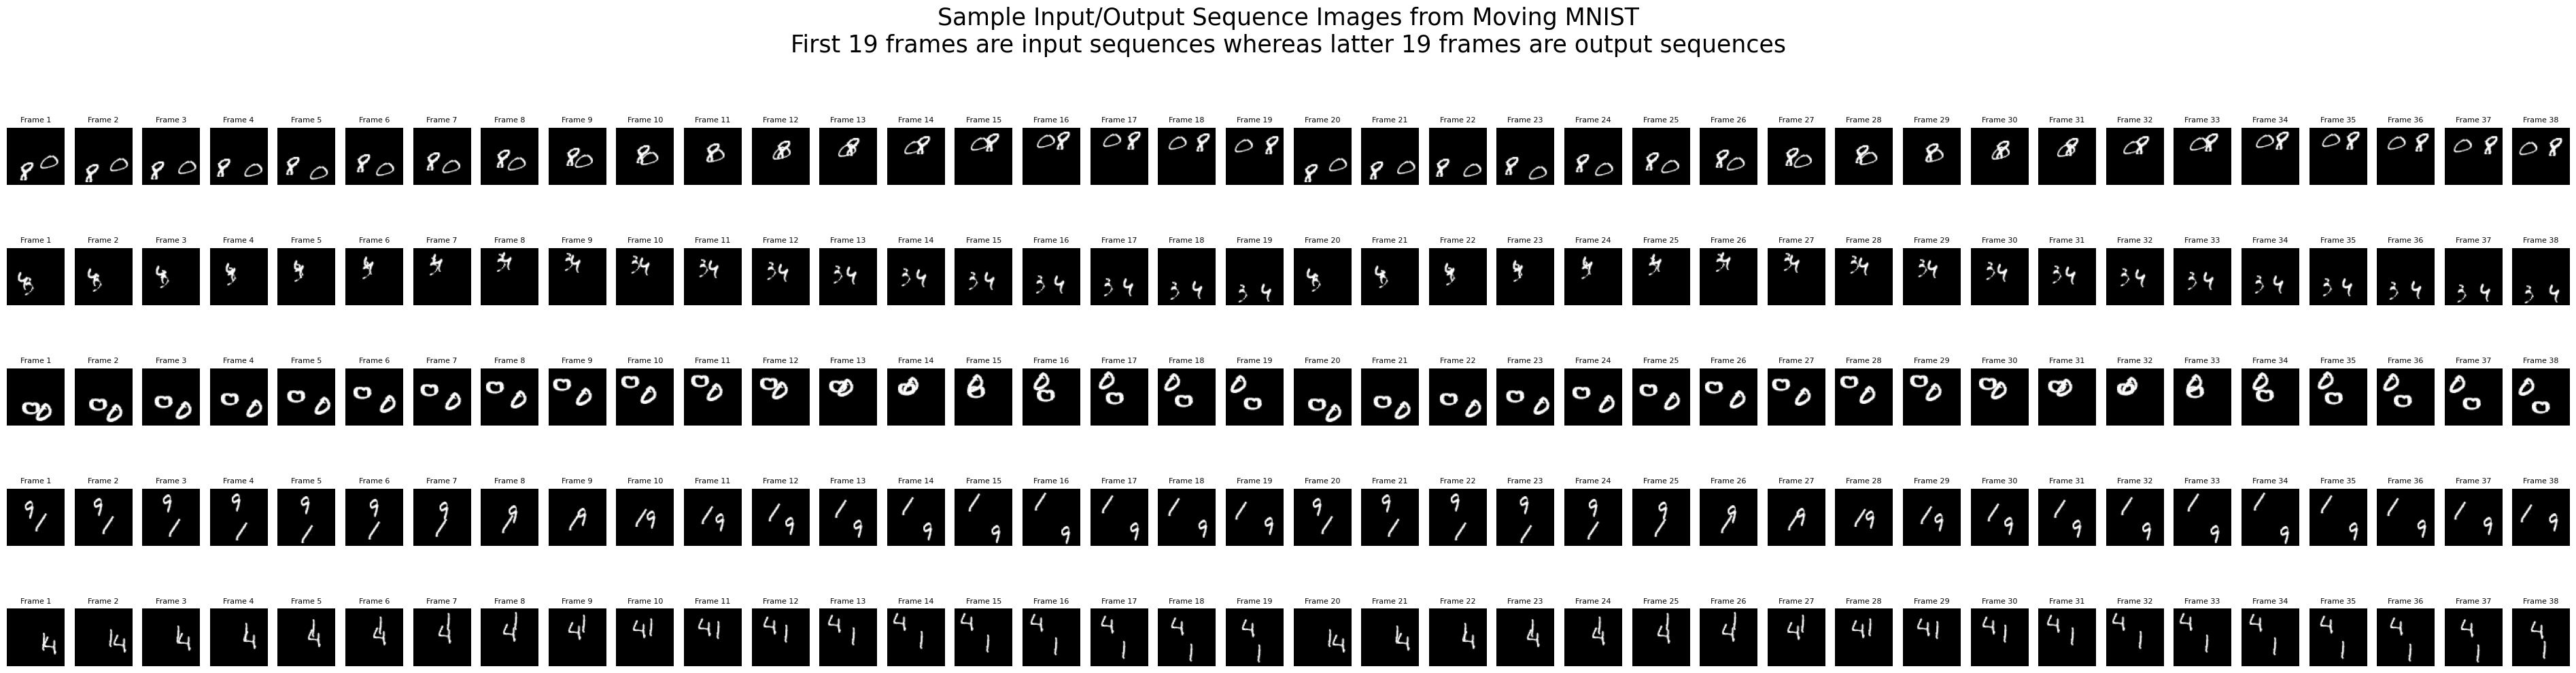

CPU times: user 12.2 s, sys: 403 ms, total: 12.6 s
Wall time: 12.2 s


In [ ]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

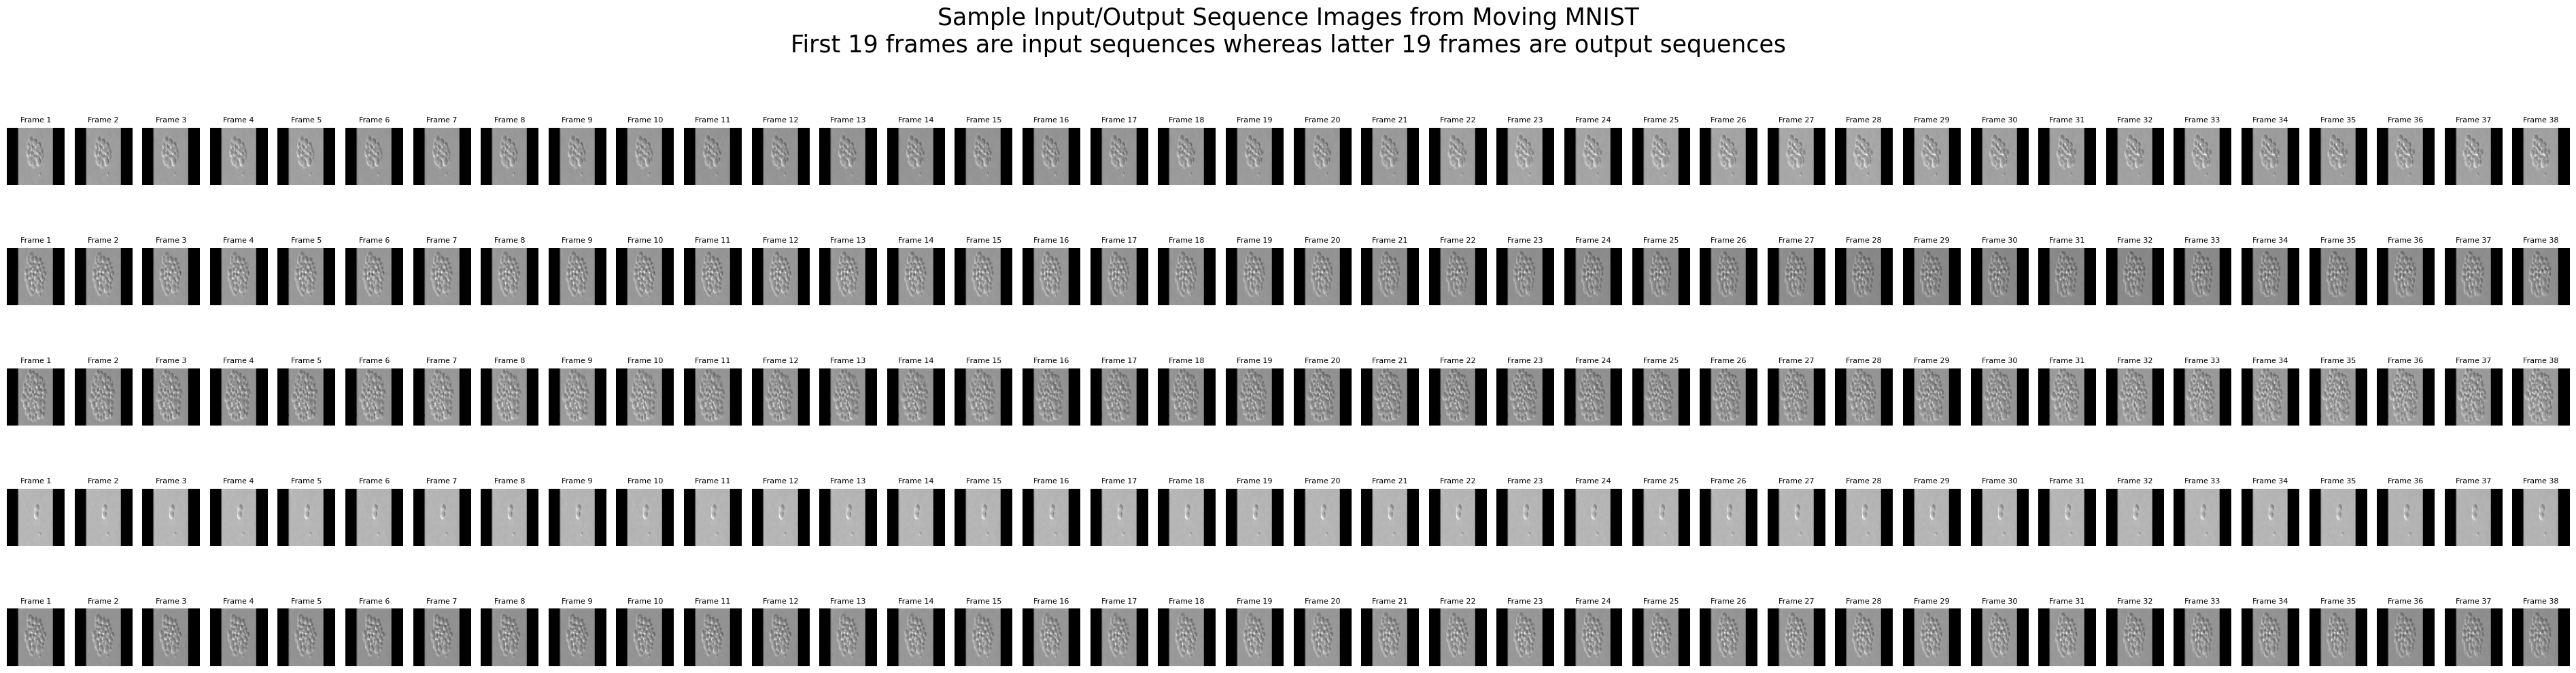

CPU times: user 10.7 s, sys: 377 ms, total: 11.1 s
Wall time: 10.7 s


In [184]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [120]:
import time
from datetime import datetime
from typing import Tuple

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output


class VAPAAD:
    """A class to handle video processing with data augmentation and self-attention mechanisms."""

    def __init__(self, input_shape: Tuple[int, int, int]):
        self.input_shape = input_shape
        # Initialize generator and instructor models
        self.gen_main = self.build_generator()
        self.gen_aux = self.build_generator()
        self.instructor = self.build_instructor()
        # Define loss functions and optimizers
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

    def build_generator(self) -> keras.Model:
        """
        Constructs the generator model for video processing with data augmentation and self-attention.

        This method is responsible for creating a generator model that performs augmentations on input
        frames and then processes them through ConvLSTM2D layers with self-attention, finally applying a
        convolution across the time dimension to generate output frames.

        The model is part of a generative approach and could be used in tasks such as video frame prediction,
        unsupervised learning, or as a part of a Generative Adversarial Network (GAN).

        Returns:
            A Keras model that takes a sequence of frames as input, augments them via random zooming, rotations,
            and translations, and then outputs processed frames with the same sequence length as the input.

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is expected
        to be either a predefined layer in Keras or a custom implementation provided in the code.

        Example usage:
            generator = build_generator()
        """
        # Data augmentation layers intended to increase robustness and generalization
        data_augmentation = keras.Sequential(
            [
                layers.RandomZoom(height_factor=0.02, width_factor=0.02),
                layers.RandomRotation(factor=0.02),
                layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
            ],
            name="data_augmentation",
        )

        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Apply time distributed data augmentation which applies the augmentation to each frame independently
        x = layers.TimeDistributed(data_augmentation)(inp)
        # Convolutional LSTM layer with relu activation to capture temporal features
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(5, 5),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(x)
        # Batch normalization to help maintain the stability of the network
        x = layers.BatchNormalization()(x)
        # Self-attention layer for capturing long-range dependencies within the sequences
        x = SelfAttention()(x)
        # Conv3D layer to process the features obtained from previous layers and produce a sequence of frames
        x = layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        )(x)

        # Construct the model with the specified input and output tensors
        return keras.models.Model(inputs=inp, outputs=x)

    def build_instructor(self) -> keras.Model:
        """
        Constructs the instructor model with convolutional LSTM and fully connected layers.

        This method specifically builds a video processing instructor model that uses ConvLSTM2D layers,
        followed by self-attention, global average pooling, and dense layers to process the input frames
        and predict a one-dimensional output.

        The architecture is designed for sequential data processing ideal for video or time-series data.

        Returns:
            A compiled Keras model that takes a sequence of frames as input and outputs a
            one-dimensional tensor after processing through ConvLSTM2D, self-attention,
            and dense layers. The output can be interpreted as the probability of a certain
            class or a value depending on the final activation function used (sigmoid in this case).

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is
        assumed to be a pre-defined layer or a custom layer implemented elsewhere in the code.

        Example usage:
            model = build_instructor()
        """
        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Convolutional LSTM layer with relu activation
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(inp)
        # Batch Normalization layer
        x = layers.BatchNormalization()(x)
        # Self-attention layer for sequence learning
        x = SelfAttention()(x)
        # Global Average Pooling across the frames to get a feature vector
        x = layers.GlobalAveragePooling3D()(x)
        # Fully connected layers with relu activation
        x = layers.Dense(1024, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        # Output layer with sigmoid activation for binary classification or regression tasks
        output = layers.Dense(1, activation="sigmoid")(x)

        # Construct the model with specified layers
        return keras.models.Model(inputs=inp, outputs=output)

    def train_step(
        self, images: tf.Tensor, future_images: tf.Tensor
    ) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Perform a single training step by updating the generator and instructor models.

        This method applies gradient descent to both the generator and the instructor models
        based on the loss computed from the real and generated images.

        Args:
            images (tf.Tensor): A tensor of input images for the current time step provided
                                to the generator model 'gen_main'.
            future_images (tf.Tensor): A tensor of target images for the future time step provided
                                    to the generator model 'gen_aux'.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing the loss values for the generator model
                                        ('gen_loss') and the instructor model ('inst_loss').

        Note: 'gen_optimizer' and 'inst_optimizer' should be attributes of the class instance.

        The function uses TensorFlow operations and assumes that 'gen_main', 'gen_aux', 'instructor',
        'generator_optimizer', 'instructor_optimizer', 'generator_loss', and 'instructor_loss' are
        defined as attributes of the class in which this method is implemented.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
            # Generate outputs for both current and future inputs
            output_main = self.gen_main(images, training=True)
            output_aux = self.gen_aux(future_images, training=True)
            real_output = self.instructor(output_aux, training=True)
            fake_output = self.instructor(output_main, training=True)

            # Calculate losses for both models
            gen_loss = self.generator_loss(fake_output)
            inst_loss = self.instructor_loss(real_output, fake_output)

        # Apply gradients to update model weights
        gradients_of_gen = gen_tape.gradient(
            gen_loss, self.gen_main.trainable_variables
        )
        gradients_of_inst = inst_tape.gradient(
            inst_loss, self.instructor.trainable_variables
        )
        self.generator_optimizer.apply_gradients(
            zip(gradients_of_gen, self.gen_main.trainable_variables)
        )
        self.instructor_optimizer.apply_gradients(
            zip(gradients_of_inst, self.instructor.trainable_variables)
        )

        return gen_loss, inst_loss

    def generator_loss(self, fake_output):
        """
        Calculates the loss for the generator model based on its output for generated (fake) images.

        The loss encourages the generator to produce images that the instructor model classifies as real.
        This is achieved by comparing the generator's output for fake images against a target tensor of ones,
        indicating that the ideal output of the generator would be classified as real by the instructor model.

        Args:
        fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def instructor_loss(self, real_output, fake_output):
        """
        Calculates the loss for the instructor model based on its output for real and generated (fake) images.

        The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
        the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

        Args:
        real_output (tf.Tensor): The instructor model's output logits for real images.
        fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
        """
        # Define real_loss and fake_loss
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def train(self, x_train, y_train, batch_size=64):
        """
        Trains the model for a specified batch size.

        This function iterates over the entire dataset for a epoch,
        randomly selecting batches of data to perform training steps. The selection is random
        and without replacement within each epoch, ensuring diverse exposure of data.

        Args:
        x_train (np.ndarray): The input training data.
        y_train (np.ndarray): The target training data.
        batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

        Returns:
        None
        """
        n_samples = x_train.shape[0]
        start = time.time()
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            if i + batch_size > n_samples:
                continue  # Avoid index error on the last batch if it's smaller than the batch size
            selected_indices = indices[i : i + batch_size]
            x_batch = x_train[selected_indices]
            y_batch = y_train[selected_indices]
            curr_gen_loss, curr_inst_loss = self.train_step(x_batch, y_batch)
            if curr_gen_loss < 0.2:  # Early stopping condition
                print(f"Stopping early at epoch {i + 1}")
                return

            print(
                f"> running: current sample {i + 1}, gen_loss={curr_gen_loss}, inst_loss={curr_inst_loss}, time={time.time() - start} sec"
            )

    def __read_me__(self):
        """
        This function prints a multi-line formatted instruction manual for running a VAPAAD model.

        The instructions include how to inspect the data shapes of training and validation datasets,
        initializing the VAPAAD model, selecting a random subset of the training data for training,
        and finally, running the model with GPU support if available.

        There are no parameters for this function and it doesn't return anything.
        It simply prints the instructional text to the console when called.
        """
        now = datetime.now()
        current_year = now.year
        print(
            f"""
            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_train[indices]
            print(x_train_sub.shape, y_train_sub.shape)

            # Example usage:
            BATCH_SIZE = 3
            if tf.test.gpu_device_name() != '':
                with tf.device('/device:GPU:0'):
                    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            else:
                vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            ```

            Copyright © 2010-{current_year} Present Yiqiao Yin
            """
        )


## Get Ready for Training

In [139]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (695, 19, 64, 64, 1), (695, 19, 64, 64, 1)
Validation Dataset Shapes: (174, 19, 64, 64, 1), (174, 19, 64, 64, 1)


### Convert to `16bit` data

In [140]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [141]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [142]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[ 74 507 479 693 550 467]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


## Define model: `VAPAAD`

In [257]:
# Initializing a new VAPAAD model
vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

In [258]:
# readme
vapaad_model.__read_me__()


            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_t

### Train

In [259]:
%%time

# Epochs
NUM_OF_EP = 1

# Training
for iii in range(NUM_OF_EP):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 32
    indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    BATCH_SIZE = 3
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
    else:
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

    print("Epoch: " + str(iii+1))

[111  21 123  23  82 111]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7006298899650574, inst_loss=1.3834822177886963, time=4.720492601394653 sec
> running: current sample 4, gen_loss=0.6996534466743469, inst_loss=1.3812814950942993, time=6.3517255783081055 sec
> running: current sample 7, gen_loss=0.7077545523643494, inst_loss=1.3740167617797852, time=7.979592323303223 sec
> running: current sample 10, gen_loss=0.6985495686531067, inst_loss=1.3856080770492554, time=9.502512454986572 sec
> running: current sample 13, gen_loss=0.7150557041168213, inst_loss=1.3679817914962769, time=11.01693844795227 sec
> running: current sample 16, gen_loss=0.7112919688224792, inst_loss=1.365312099456787, time=12.539511442184448 sec
> running: current sample 19, gen_loss=0.709580659866333, inst_loss=1.3680368661880493, time=14.066427230834961 sec
> running: current sample 22, gen_loss=0.7321521639823914, inst_loss=1.3440144062042236, time=15.558298349380493 sec
> runni

### Extract generator

In [260]:
# Assuming you have a method to get the trained generator
trained_generator = vapaad_model.gen_main

### Prediction Using Generator

In [261]:
%%time

# prediction on validation set
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        y_val_pred = trained_generator.predict(x_val)
else:
    y_val_pred = trained_generator.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

2/2 [==============================] - 1s 146ms/step
Shape of true y_val: (35, 19, 64, 64, 1)
Shape of predicted y_val: (35, 19, 64, 64, 1)
CPU times: user 457 ms, sys: 57.5 ms, total: 515 ms
Wall time: 1.06 s


## Visualization

In [159]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    Q = 32  # Number of levels
    discretized_image = np.round(normalized_image * Q) / (Q+1)  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

Moving MNIST

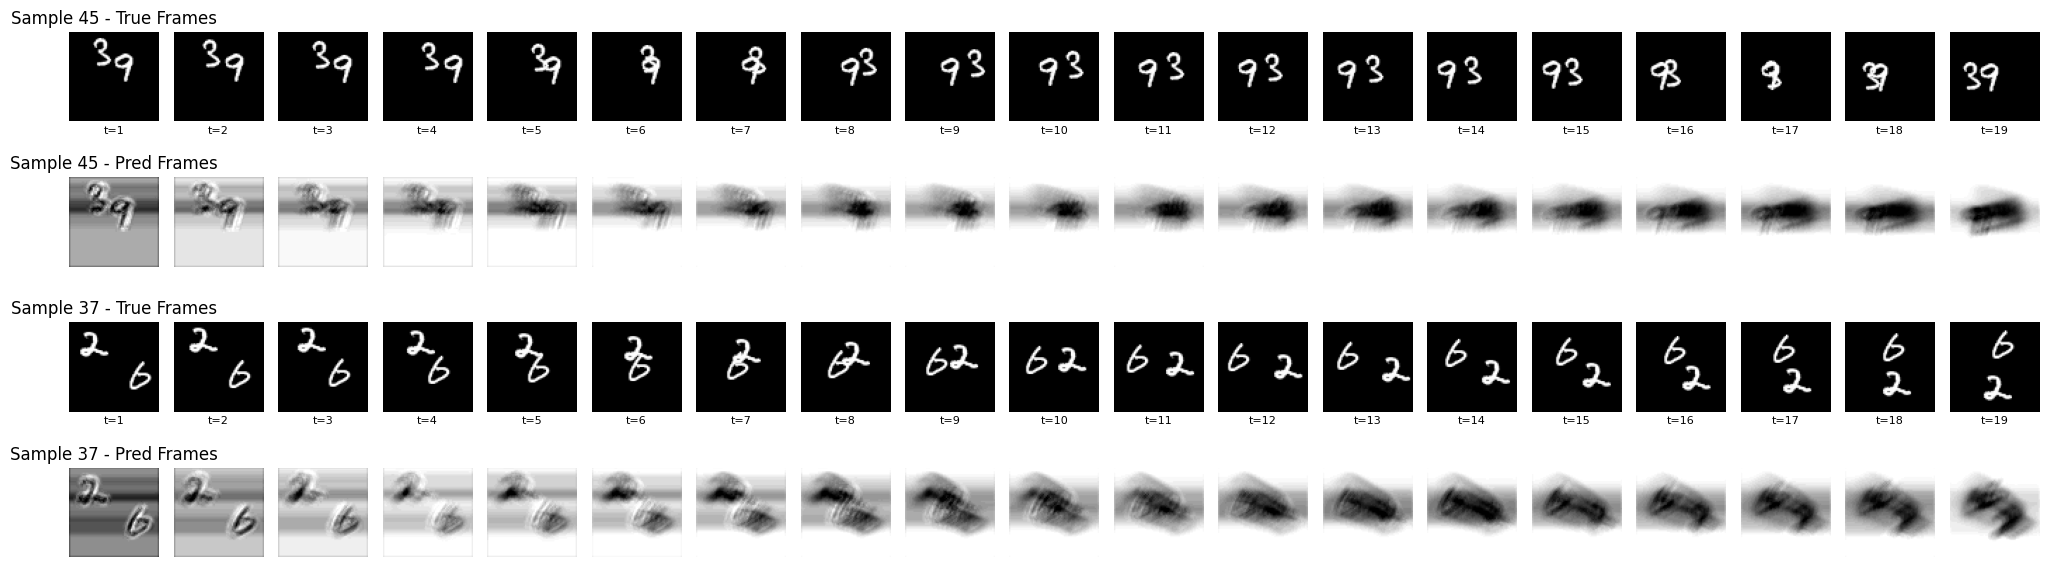

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

Ecoli

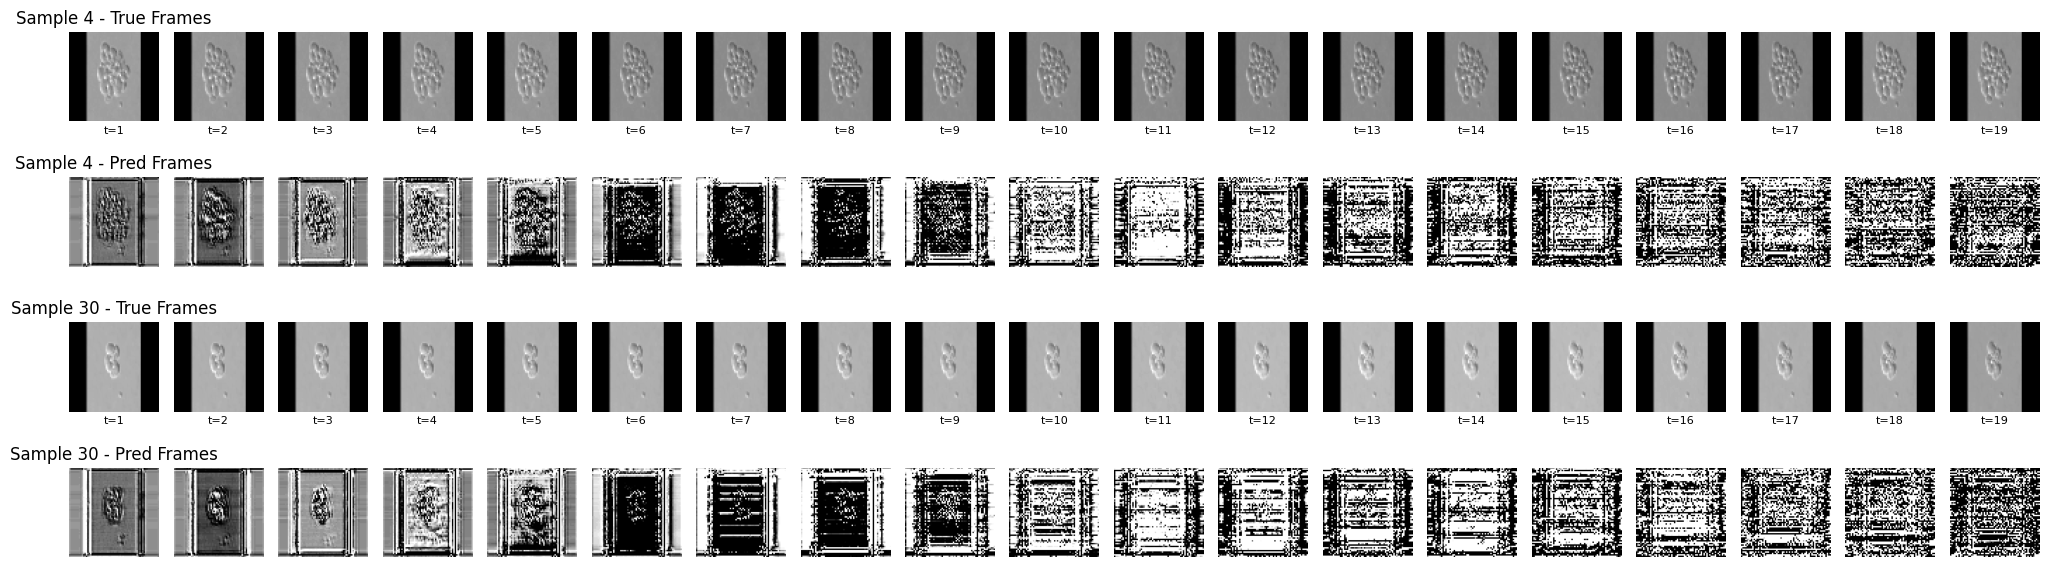

In [262]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

## Create `.gif`

Moving MNIST

In [95]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = rescale_and_discretize(new_prediction)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 57ms/step
Truth	Prediction


Ecoli

In [243]:
x_val[np.random.choice(range(len(x_val)), size=5)]

(5, 19, 64, 64, 1)

In [237]:
val_dataset[np.random.choice(range(len(val_dataset)), size=5)].shape

(5, 20, 64, 64, 1)

In [252]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_ecoli_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = x_val[np.random.choice(range(len(x_val)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = rescale_and_discretize(new_prediction)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 67ms/step
Truth	Prediction


#### Moving MNIST

In [79]:
%%time

# Epochs
NUM_OF_EP = 20
for iii in range(NUM_OF_EP):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 64
    indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    BATCH_SIZE = 3
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
    else:
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

    print("Epoch: " + str(iii+1))

    # Assuming you have a method to get the trained generator
    trained_generator = vapaad_model.gen_main

    if True:
        # Create a directory for the GIFs
        gif_dir = "predicted_gifs_ecoli_instruct_vapaad_stop_grad"
        os.makedirs(gif_dir, exist_ok=True)

        # Select a few random examples from the dataset.
        examples = x_val[np.random.choice(range(len(x_val)), size=5)]

        # Iterate over the examples and predict the frames.
        predicted_videos = []
        for index, example in enumerate(examples):
            # Pick the first/last ten frames from the example.
            frames = example[:10, ...]
            original_frames = example[10:, ...]
            new_predictions = np.zeros(shape=(10, *frames[0].shape))

            # Predict a new set of 10 frames.
            for i in range(10):
                # Extract the generator's prediction and post-process it.
                frames = example[: 10 + i + 1, ...]
                new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
                new_prediction = rescale_and_discretize(new_prediction)
                new_prediction = np.squeeze(new_prediction, axis=0)
                predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

                # Extend the set of prediction frames.
                new_predictions[i] = predicted_frame

            # Create and save GIFs for each of the ground truth/prediction images.
            for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
                # Construct a GIF from the selected video frames.
                current_frames = np.squeeze(frame_set)
                current_frames = current_frames[..., np.newaxis] * np.ones(3)
                current_frames = (current_frames * 255).astype(np.uint8)
                current_frames = list(current_frames)

                # Define the GIF filepath
                gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

                # Save the GIF
                imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

                # To display the videos inline, you can open and read the saved GIF
                with open(gif_filename, 'rb') as gif_file:
                    predicted_videos.append(gif_file.read())

        # Display the videos inline in the notebook.
        print("Truth\tPrediction")
        for i in range(0, len(predicted_videos), 2):
            box = HBox(
                [
                    widgets.Image(value=predicted_videos[i], format='gif'),
                    widgets.Image(value=predicted_videos[i + 1], format='gif'),
                ]
            )
            display(box)


[127 204 562 813 586 831]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6946622729301453, inst_loss=1.3778226375579834, time=1.613069772720337 sec
> running: current sample 4, gen_loss=0.6948124766349792, inst_loss=1.377895474433899, time=3.136775255203247 sec
> running: current sample 7, gen_loss=0.7092525362968445, inst_loss=1.3697274923324585, time=4.671069145202637 sec
> running: current sample 10, gen_loss=0.71055668592453, inst_loss=1.3641163110733032, time=6.2038233280181885 sec
> running: current sample 13, gen_loss=0.7231351733207703, inst_loss=1.3518891334533691, time=7.734997987747192 sec
> running: current sample 16, gen_loss=0.7548481822013855, inst_loss=1.3274509906768799, time=9.283901691436768 sec
> running: current sample 19, gen_loss=0.7344793677330017, inst_loss=1.339777946472168, time=10.92004680633545 sec
> running: current sample 22, gen_loss=0.7456986308097839, inst_loss=1.3259763717651367, time=12.463809251785278 sec
> running: 

[196  71  93 813 686 605]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6596236824989319, inst_loss=1.4257853031158447, time=1.5556972026824951 sec
> running: current sample 4, gen_loss=0.6601385474205017, inst_loss=1.427170991897583, time=3.0916848182678223 sec
> running: current sample 7, gen_loss=0.6671962738037109, inst_loss=1.442381501197815, time=4.6157214641571045 sec
> running: current sample 10, gen_loss=0.6671006083488464, inst_loss=1.4466854333877563, time=6.116411447525024 sec
> running: current sample 13, gen_loss=0.6634588241577148, inst_loss=1.4205591678619385, time=7.643482208251953 sec
> running: current sample 16, gen_loss=0.6598228812217712, inst_loss=1.4106037616729736, time=9.184330701828003 sec
> running: current sample 19, gen_loss=0.6530017256736755, inst_loss=1.4155042171478271, time=10.707710981369019 sec
> running: current sample 22, gen_loss=0.6510164141654968, inst_loss=1.3966724872589111, time=12.212042808532715 sec
> runn

[686 743 183 657 271 102]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6576550006866455, inst_loss=1.3932554721832275, time=1.5361528396606445 sec
> running: current sample 4, gen_loss=0.666567325592041, inst_loss=1.4020836353302002, time=3.058807611465454 sec
> running: current sample 7, gen_loss=0.6708754897117615, inst_loss=1.3949449062347412, time=4.582880973815918 sec
> running: current sample 10, gen_loss=0.6755738258361816, inst_loss=1.3935986757278442, time=6.084327697753906 sec
> running: current sample 13, gen_loss=0.6881545186042786, inst_loss=1.4068963527679443, time=7.621207237243652 sec
> running: current sample 16, gen_loss=0.6826055645942688, inst_loss=1.3989274501800537, time=9.127863883972168 sec
> running: current sample 19, gen_loss=0.6793362498283386, inst_loss=1.393942952156067, time=10.62698221206665 sec
> running: current sample 22, gen_loss=0.6812840104103088, inst_loss=1.4008128643035889, time=12.139248132705688 sec
> running

[ 99 340 652 705 861  42]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.812279224395752, inst_loss=1.3329432010650635, time=1.530144214630127 sec
> running: current sample 4, gen_loss=0.8224589228630066, inst_loss=1.3441425561904907, time=3.0399932861328125 sec
> running: current sample 7, gen_loss=0.8530089855194092, inst_loss=1.3419883251190186, time=4.557580947875977 sec
> running: current sample 10, gen_loss=1.0164088010787964, inst_loss=1.271679162979126, time=6.092501878738403 sec
> running: current sample 13, gen_loss=1.3380235433578491, inst_loss=1.3611021041870117, time=7.617990255355835 sec
> running: current sample 16, gen_loss=1.2985823154449463, inst_loss=1.4040943384170532, time=9.139628887176514 sec
> running: current sample 19, gen_loss=1.0494505167007446, inst_loss=1.412539005279541, time=10.62960958480835 sec
> running: current sample 22, gen_loss=0.8350573182106018, inst_loss=1.4465256929397583, time=12.153441429138184 sec
> running:

[593 474 655 683 878 157]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6625543236732483, inst_loss=1.3664066791534424, time=1.506753921508789 sec
> running: current sample 4, gen_loss=0.6659044027328491, inst_loss=1.3570568561553955, time=3.0145862102508545 sec
> running: current sample 7, gen_loss=0.6600165963172913, inst_loss=1.347888469696045, time=4.529288291931152 sec
> running: current sample 10, gen_loss=0.6492106318473816, inst_loss=1.3404827117919922, time=6.11407470703125 sec
> running: current sample 13, gen_loss=0.6403850317001343, inst_loss=1.3330631256103516, time=7.628154277801514 sec
> running: current sample 16, gen_loss=0.6200365424156189, inst_loss=1.3401875495910645, time=9.14926290512085 sec
> running: current sample 19, gen_loss=0.6177294850349426, inst_loss=1.3291752338409424, time=10.674180030822754 sec
> running: current sample 22, gen_loss=0.6195853352546692, inst_loss=1.3117629289627075, time=12.196898937225342 sec
> running

[167 457 773 567 522 825]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6626901030540466, inst_loss=1.3896925449371338, time=1.5230634212493896 sec
> running: current sample 4, gen_loss=0.6635494232177734, inst_loss=1.3891830444335938, time=3.027451753616333 sec
> running: current sample 7, gen_loss=0.6648775339126587, inst_loss=1.3898711204528809, time=4.579466342926025 sec
> running: current sample 10, gen_loss=0.6661702990531921, inst_loss=1.3915389776229858, time=6.096958875656128 sec
> running: current sample 13, gen_loss=0.6716499924659729, inst_loss=1.3865753412246704, time=7.605161190032959 sec
> running: current sample 16, gen_loss=0.6745854020118713, inst_loss=1.3826868534088135, time=9.12685489654541 sec
> running: current sample 19, gen_loss=0.6724936366081238, inst_loss=1.3911947011947632, time=10.636467218399048 sec
> running: current sample 22, gen_loss=0.6739237904548645, inst_loss=1.387526512145996, time=12.141906261444092 sec
> runnin

[102 180 827 393 642 558]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7814555168151855, inst_loss=1.3694263696670532, time=1.5054233074188232 sec
> running: current sample 4, gen_loss=0.794427216053009, inst_loss=1.367870807647705, time=3.0299088954925537 sec
> running: current sample 7, gen_loss=0.7795016765594482, inst_loss=1.3750004768371582, time=4.577854633331299 sec
> running: current sample 10, gen_loss=0.7658571600914001, inst_loss=1.3777837753295898, time=6.078367471694946 sec
> running: current sample 13, gen_loss=0.773259699344635, inst_loss=1.3737409114837646, time=7.570601940155029 sec
> running: current sample 16, gen_loss=0.7766380310058594, inst_loss=1.3761112689971924, time=9.075896263122559 sec
> running: current sample 19, gen_loss=0.7971823811531067, inst_loss=1.379023790359497, time=10.573051929473877 sec
> running: current sample 22, gen_loss=0.7900559902191162, inst_loss=1.389561414718628, time=12.080198287963867 sec
> running:

[364 538 266 745 714 759]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6337046027183533, inst_loss=1.3615227937698364, time=1.8446016311645508 sec
> running: current sample 4, gen_loss=0.629770040512085, inst_loss=1.3585491180419922, time=3.383960008621216 sec
> running: current sample 7, gen_loss=0.6220747828483582, inst_loss=1.3445558547973633, time=4.906667470932007 sec
> running: current sample 10, gen_loss=0.61372971534729, inst_loss=1.33902907371521, time=6.41975474357605 sec
> running: current sample 13, gen_loss=0.6191927194595337, inst_loss=1.3335462808609009, time=7.910758018493652 sec
> running: current sample 16, gen_loss=0.6098571419715881, inst_loss=1.3246046304702759, time=9.425450801849365 sec
> running: current sample 19, gen_loss=0.6114709973335266, inst_loss=1.319199800491333, time=10.94596266746521 sec
> running: current sample 22, gen_loss=0.5970527529716492, inst_loss=1.3110328912734985, time=12.445581197738647 sec
> running: cur

[502 885 637 455 105 319]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.5123568177223206, inst_loss=1.5709202289581299, time=1.527101993560791 sec
> running: current sample 4, gen_loss=0.5917561054229736, inst_loss=1.5610461235046387, time=3.4286327362060547 sec
> running: current sample 7, gen_loss=0.6894800066947937, inst_loss=1.4996986389160156, time=4.923156261444092 sec
> running: current sample 10, gen_loss=0.6894163489341736, inst_loss=1.5210298299789429, time=6.443618535995483 sec
> running: current sample 13, gen_loss=0.6941266059875488, inst_loss=1.52883780002594, time=7.960208892822266 sec
> running: current sample 16, gen_loss=0.7264013290405273, inst_loss=1.5200355052947998, time=9.467350244522095 sec
> running: current sample 19, gen_loss=0.7652327418327332, inst_loss=1.4974005222320557, time=10.99201488494873 sec
> running: current sample 22, gen_loss=0.8034809231758118, inst_loss=1.4769102334976196, time=12.500406742095947 sec
> running

[ 55 441 733 738 458 511]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7753221988677979, inst_loss=1.1001100540161133, time=1.5708389282226562 sec
> running: current sample 4, gen_loss=0.7620822787284851, inst_loss=1.092179536819458, time=3.0711452960968018 sec
> running: current sample 7, gen_loss=0.6641694903373718, inst_loss=1.1437476873397827, time=4.886256694793701 sec
> running: current sample 10, gen_loss=0.7314218878746033, inst_loss=1.067513108253479, time=6.392561197280884 sec
> running: current sample 13, gen_loss=0.5778618454933167, inst_loss=1.1962648630142212, time=7.924575328826904 sec
> running: current sample 16, gen_loss=0.5827836990356445, inst_loss=1.1751079559326172, time=9.424790620803833 sec
> running: current sample 19, gen_loss=0.6933563351631165, inst_loss=1.1000908613204956, time=10.941960334777832 sec
> running: current sample 22, gen_loss=0.7145534157752991, inst_loss=1.0778826475143433, time=12.494689226150513 sec
> runni

[878 427  62 517 539 557]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.5611509680747986, inst_loss=1.1581735610961914, time=1.5588767528533936 sec
> running: current sample 4, gen_loss=1.0996774435043335, inst_loss=1.064468502998352, time=3.0794787406921387 sec
> running: current sample 7, gen_loss=0.8632985949516296, inst_loss=1.1032119989395142, time=4.587712287902832 sec
> running: current sample 10, gen_loss=0.756766140460968, inst_loss=1.154761552810669, time=6.08900785446167 sec
> running: current sample 13, gen_loss=0.8113670349121094, inst_loss=1.274928331375122, time=7.6049957275390625 sec
> running: current sample 16, gen_loss=0.6722900867462158, inst_loss=1.324628472328186, time=9.434651374816895 sec
> running: current sample 19, gen_loss=0.6786405444145203, inst_loss=1.370510458946228, time=10.962750434875488 sec
> running: current sample 22, gen_loss=0.5736833214759827, inst_loss=1.4172391891479492, time=12.488545417785645 sec
> running: 

[803 508 223 613 526 226]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6819911003112793, inst_loss=1.4139906167984009, time=1.5230309963226318 sec
> running: current sample 4, gen_loss=0.7887663841247559, inst_loss=1.3756537437438965, time=3.0104129314422607 sec
> running: current sample 7, gen_loss=0.7878440022468567, inst_loss=1.3923687934875488, time=4.532215356826782 sec
> running: current sample 10, gen_loss=0.7373960614204407, inst_loss=1.395465612411499, time=6.031108617782593 sec
> running: current sample 13, gen_loss=0.7225648760795593, inst_loss=1.4304156303405762, time=7.523041725158691 sec
> running: current sample 16, gen_loss=0.8040722012519836, inst_loss=1.3022410869598389, time=9.020324230194092 sec
> running: current sample 19, gen_loss=0.7893197536468506, inst_loss=1.3928961753845215, time=10.548004627227783 sec
> running: current sample 22, gen_loss=0.7986114621162415, inst_loss=1.3297340869903564, time=12.368046283721924 sec
> runn

[ 39 794  64 580 696 713]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6046612858772278, inst_loss=1.331002950668335, time=1.5351758003234863 sec
> running: current sample 4, gen_loss=0.607013463973999, inst_loss=1.3410825729370117, time=3.0630486011505127 sec
> running: current sample 7, gen_loss=0.6252385973930359, inst_loss=1.3461651802062988, time=4.572582244873047 sec
> running: current sample 10, gen_loss=0.6326934695243835, inst_loss=1.3737300634384155, time=6.096787452697754 sec
> running: current sample 13, gen_loss=0.7006205916404724, inst_loss=1.3503214120864868, time=7.609243154525757 sec
> running: current sample 16, gen_loss=0.7463750839233398, inst_loss=1.3004999160766602, time=9.150516033172607 sec
> running: current sample 19, gen_loss=0.8390445709228516, inst_loss=1.3521366119384766, time=11.02637767791748 sec
> running: current sample 22, gen_loss=0.9135739803314209, inst_loss=1.4217419624328613, time=12.55314326286316 sec
> running

[421 177 274  63 874 572]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.9757061004638672, inst_loss=1.2211742401123047, time=1.5339863300323486 sec
> running: current sample 4, gen_loss=1.076034426689148, inst_loss=1.1756540536880493, time=3.0575833320617676 sec
> running: current sample 7, gen_loss=0.90504390001297, inst_loss=1.184067964553833, time=4.576280117034912 sec
> running: current sample 10, gen_loss=1.1511229276657104, inst_loss=1.2288671731948853, time=6.095408201217651 sec
> running: current sample 13, gen_loss=0.8232123255729675, inst_loss=1.3766955137252808, time=7.620059013366699 sec
> running: current sample 16, gen_loss=1.0664567947387695, inst_loss=1.3234994411468506, time=9.158650875091553 sec
> running: current sample 19, gen_loss=1.1700044870376587, inst_loss=1.4194709062576294, time=10.672682523727417 sec
> running: current sample 22, gen_loss=1.1274280548095703, inst_loss=1.4079867601394653, time=12.176479578018188 sec
> running

[812 196 390  38 259 152]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.9114174246788025, inst_loss=1.14460027217865, time=1.5529935359954834 sec
> running: current sample 4, gen_loss=0.7609118819236755, inst_loss=1.2734637260437012, time=3.08555006980896 sec
> running: current sample 7, gen_loss=0.9434903264045715, inst_loss=1.2177051305770874, time=4.595215082168579 sec
> running: current sample 10, gen_loss=0.9540770649909973, inst_loss=1.3430594205856323, time=6.130073547363281 sec
> running: current sample 13, gen_loss=0.8726057410240173, inst_loss=1.234652042388916, time=7.657782077789307 sec
> running: current sample 16, gen_loss=0.9031691551208496, inst_loss=1.122630000114441, time=9.177202463150024 sec
> running: current sample 19, gen_loss=0.7644099593162537, inst_loss=1.2610546350479126, time=10.698668003082275 sec
> running: current sample 22, gen_loss=0.6538204550743103, inst_loss=1.3011648654937744, time=12.239684343338013 sec
> running: 

[404 503 148 545 815 167]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7282927632331848, inst_loss=1.2631171941757202, time=1.5219290256500244 sec
> running: current sample 4, gen_loss=0.7327463030815125, inst_loss=1.264078140258789, time=3.038752555847168 sec
> running: current sample 7, gen_loss=0.8004311919212341, inst_loss=1.2390358448028564, time=4.578133821487427 sec
> running: current sample 10, gen_loss=0.9498932361602783, inst_loss=1.2560081481933594, time=6.114277601242065 sec
> running: current sample 13, gen_loss=0.94191974401474, inst_loss=1.2372398376464844, time=7.651557922363281 sec
> running: current sample 16, gen_loss=0.9280190467834473, inst_loss=1.1984150409698486, time=9.170771598815918 sec
> running: current sample 19, gen_loss=0.9084030985832214, inst_loss=1.3174397945404053, time=10.68327522277832 sec
> running: current sample 22, gen_loss=1.0660820007324219, inst_loss=1.345116376876831, time=12.17193341255188 sec
> running: c

[ 18 428 591 705 315 618]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.9543541073799133, inst_loss=1.2407422065734863, time=1.569584846496582 sec
> running: current sample 4, gen_loss=0.6782072186470032, inst_loss=1.2962983846664429, time=3.1374471187591553 sec
> running: current sample 7, gen_loss=0.9933557510375977, inst_loss=1.4159194231033325, time=4.663290500640869 sec
> running: current sample 10, gen_loss=1.0357134342193604, inst_loss=1.7718240022659302, time=6.178082227706909 sec
> running: current sample 13, gen_loss=0.5029520988464355, inst_loss=1.5209459066390991, time=7.708846092224121 sec
> running: current sample 16, gen_loss=0.589231014251709, inst_loss=1.4395740032196045, time=9.248834371566772 sec
> running: current sample 19, gen_loss=0.5680074691772461, inst_loss=1.4806857109069824, time=10.775617122650146 sec
> running: current sample 22, gen_loss=0.6068270802497864, inst_loss=1.4008175134658813, time=12.285568952560425 sec
> runni

[808  13 603 155 841 640]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7170639038085938, inst_loss=1.4155170917510986, time=1.5839331150054932 sec
> running: current sample 4, gen_loss=0.7691451907157898, inst_loss=1.3841806650161743, time=3.1254055500030518 sec
> running: current sample 7, gen_loss=0.6841485500335693, inst_loss=1.4266293048858643, time=4.633701801300049 sec
> running: current sample 10, gen_loss=0.6999296545982361, inst_loss=1.3987205028533936, time=6.1641526222229 sec
> running: current sample 13, gen_loss=0.690727174282074, inst_loss=1.3658055067062378, time=7.682957887649536 sec
> running: current sample 16, gen_loss=0.9336655735969543, inst_loss=1.264812707901001, time=9.218133926391602 sec
> running: current sample 19, gen_loss=1.6400357484817505, inst_loss=1.819697618484497, time=10.744685411453247 sec
> running: current sample 22, gen_loss=1.297751784324646, inst_loss=1.4578475952148438, time=12.265248537063599 sec
> running: 

[282  38 587 576 741  67]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7482842803001404, inst_loss=1.4506020545959473, time=1.5902509689331055 sec
> running: current sample 4, gen_loss=0.8556849360466003, inst_loss=1.4782054424285889, time=3.1026113033294678 sec
> running: current sample 7, gen_loss=0.9652265906333923, inst_loss=1.3575587272644043, time=4.611557722091675 sec
> running: current sample 10, gen_loss=0.9031583666801453, inst_loss=1.4022612571716309, time=6.11267614364624 sec
> running: current sample 13, gen_loss=1.0984188318252563, inst_loss=1.3016725778579712, time=7.633313179016113 sec
> running: current sample 16, gen_loss=1.1866557598114014, inst_loss=1.1786617040634155, time=9.143840074539185 sec
> running: current sample 19, gen_loss=0.6380513906478882, inst_loss=1.4138031005859375, time=10.638070106506348 sec
> running: current sample 22, gen_loss=0.6446968913078308, inst_loss=1.4073338508605957, time=12.16599726676941 sec
> runni

[608 530 627 629 219 468]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.8364900946617126, inst_loss=1.410699725151062, time=1.5265476703643799 sec
> running: current sample 4, gen_loss=0.79061359167099, inst_loss=1.3791835308074951, time=3.050494432449341 sec
> running: current sample 7, gen_loss=0.7505490183830261, inst_loss=1.362351655960083, time=4.8904993534088135 sec
> running: current sample 10, gen_loss=0.7598150372505188, inst_loss=1.3885178565979004, time=6.422796249389648 sec
> running: current sample 13, gen_loss=0.702007532119751, inst_loss=1.409102439880371, time=7.922972917556763 sec
> running: current sample 16, gen_loss=0.6657235026359558, inst_loss=1.399777889251709, time=9.439793586730957 sec
> running: current sample 19, gen_loss=0.6407037973403931, inst_loss=1.4149117469787598, time=10.962435007095337 sec
> running: current sample 22, gen_loss=0.6210541129112244, inst_loss=1.4079647064208984, time=12.530686855316162 sec
> running: c

CPU times: user 11min 53s, sys: 13.4 s, total: 12min 6s
Wall time: 12min 16s


#### Ecoli

In [263]:
%%time

# Epochs
NUM_OF_EP = 20
for iii in range(NUM_OF_EP):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 32
    indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    BATCH_SIZE = 3
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
    else:
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

    print("Epoch: " + str(iii+1))

    # Assuming you have a method to get the trained generator
    trained_generator = vapaad_model.gen_main

    if True:
        # Create a directory for the GIFs
        gif_dir = "predicted_gifs_ecoli_instruct_vapaad_stop_grad"
        os.makedirs(gif_dir, exist_ok=True)

        # Select a few random examples from the dataset.
        examples = x_val[np.random.choice(range(len(x_val)), size=5)]

        # Iterate over the examples and predict the frames.
        predicted_videos = []
        for index, example in enumerate(examples):
            # Pick the first/last ten frames from the example.
            frames = example[:10, ...]
            original_frames = example[10:, ...]
            new_predictions = np.zeros(shape=(10, *frames[0].shape))

            # Predict a new set of 10 frames.
            for i in range(10):
                # Extract the generator's prediction and post-process it.
                frames = example[: 10 + i + 1, ...]
                new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
                new_prediction = rescale_and_discretize(new_prediction)
                new_prediction = np.squeeze(new_prediction, axis=0)
                predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

                # Extend the set of prediction frames.
                new_predictions[i] = predicted_frame

            # Create and save GIFs for each of the ground truth/prediction images.
            for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
                # Construct a GIF from the selected video frames.
                current_frames = np.squeeze(frame_set)
                current_frames = current_frames[..., np.newaxis] * np.ones(3)
                current_frames = (current_frames * 255).astype(np.uint8)
                current_frames = list(current_frames)

                # Define the GIF filepath
                gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

                # Save the GIF
                imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

                # To display the videos inline, you can open and read the saved GIF
                with open(gif_filename, 'rb') as gif_file:
                    predicted_videos.append(gif_file.read())

        # Display the videos inline in the notebook.
        print("Truth\tPrediction")
        for i in range(0, len(predicted_videos), 2):
            box = HBox(
                [
                    widgets.Image(value=predicted_videos[i], format='gif'),
                    widgets.Image(value=predicted_videos[i + 1], format='gif'),
                ]
            )
            display(box)


[71 90 57 68 13 12]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7022477984428406, inst_loss=1.3715925216674805, time=1.7529518604278564 sec
> running: current sample 4, gen_loss=0.735912024974823, inst_loss=1.3395705223083496, time=3.397324562072754 sec
> running: current sample 7, gen_loss=0.727855920791626, inst_loss=1.3446621894836426, time=5.0251171588897705 sec
> running: current sample 10, gen_loss=0.7052077651023865, inst_loss=1.3622277975082397, time=6.714313745498657 sec
> running: current sample 13, gen_loss=0.729280948638916, inst_loss=1.3523528575897217, time=8.384414911270142 sec
> running: current sample 16, gen_loss=0.7436673045158386, inst_loss=1.3234933614730835, time=10.012645483016968 sec
> running: current sample 19, gen_loss=0.7255821824073792, inst_loss=1.3396413326263428, time=11.63045072555542 sec
> running: current sample 22, gen_loss=0.7134689688682556, inst_loss=1.344838261604309, time=13.282210350036621 sec
> running: curr

[130  11  72  37  94 125]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.7587687373161316, inst_loss=1.2965173721313477, time=1.6154654026031494 sec
> running: current sample 4, gen_loss=0.763822078704834, inst_loss=1.3063673973083496, time=3.253941297531128 sec
> running: current sample 7, gen_loss=0.787568986415863, inst_loss=1.2697575092315674, time=4.867023944854736 sec
> running: current sample 10, gen_loss=0.818458616733551, inst_loss=1.2587908506393433, time=6.495699644088745 sec
> running: current sample 13, gen_loss=0.8533363938331604, inst_loss=1.236072301864624, time=8.15116834640503 sec
> running: current sample 16, gen_loss=0.8954210877418518, inst_loss=1.2103230953216553, time=9.75663948059082 sec
> running: current sample 19, gen_loss=0.8997649550437927, inst_loss=1.206829309463501, time=11.799858093261719 sec
> running: current sample 22, gen_loss=0.9190723299980164, inst_loss=1.1721429824829102, time=13.43314266204834 sec
> running: cur

[67 87 86 17 23 20]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=1.0030627250671387, inst_loss=1.1760506629943848, time=1.6117019653320312 sec
> running: current sample 4, gen_loss=0.9399567246437073, inst_loss=1.1726261377334595, time=3.1555092334747314 sec
> running: current sample 7, gen_loss=0.9768271446228027, inst_loss=1.1476988792419434, time=4.71306037902832 sec
> running: current sample 10, gen_loss=0.9116417765617371, inst_loss=1.1674318313598633, time=6.250197410583496 sec
> running: current sample 13, gen_loss=0.823830783367157, inst_loss=1.215679407119751, time=7.776433706283569 sec
> running: current sample 16, gen_loss=0.7020346522331238, inst_loss=1.2831465005874634, time=9.324626922607422 sec
> running: current sample 19, gen_loss=0.6772584915161133, inst_loss=1.3020886182785034, time=10.900103092193604 sec
> running: current sample 22, gen_loss=0.6545338034629822, inst_loss=1.3122162818908691, time=12.450789451599121 sec
> running: cur

[120  20  37 121  87  63]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6422846913337708, inst_loss=1.3035764694213867, time=1.5996012687683105 sec
> running: current sample 4, gen_loss=0.6371821165084839, inst_loss=1.3078588247299194, time=3.1358981132507324 sec
> running: current sample 7, gen_loss=0.8188943862915039, inst_loss=1.148963451385498, time=4.6961164474487305 sec
> running: current sample 10, gen_loss=0.7319428324699402, inst_loss=1.2277495861053467, time=6.293999433517456 sec
> running: current sample 13, gen_loss=0.6887149810791016, inst_loss=1.2818856239318848, time=7.819676637649536 sec
> running: current sample 16, gen_loss=0.7250661849975586, inst_loss=1.2419837713241577, time=9.342821598052979 sec
> running: current sample 19, gen_loss=0.7281265258789062, inst_loss=1.250718116760254, time=10.87313461303711 sec
> running: current sample 22, gen_loss=0.7831905484199524, inst_loss=1.2260639667510986, time=12.423794269561768 sec
> runni

[119 109 113  51 136  97]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.8199916481971741, inst_loss=1.1748721599578857, time=1.6281719207763672 sec
> running: current sample 4, gen_loss=0.7272278666496277, inst_loss=1.2359626293182373, time=3.221231460571289 sec
> running: current sample 7, gen_loss=0.7160061001777649, inst_loss=1.2216546535491943, time=4.816437244415283 sec
> running: current sample 10, gen_loss=0.7586860656738281, inst_loss=1.1867332458496094, time=6.397992372512817 sec
> running: current sample 13, gen_loss=0.8627619743347168, inst_loss=1.083266019821167, time=7.99117374420166 sec
> running: current sample 16, gen_loss=0.8562890887260437, inst_loss=1.0396925210952759, time=9.599814176559448 sec
> running: current sample 19, gen_loss=0.8126532435417175, inst_loss=1.0334033966064453, time=11.183571100234985 sec
> running: current sample 22, gen_loss=0.7938048243522644, inst_loss=1.0243343114852905, time=12.745820999145508 sec
> runnin

[ 15  42  93 117  86  39]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.9193248152732849, inst_loss=0.912854790687561, time=1.5901522636413574 sec
> running: current sample 4, gen_loss=1.0471707582473755, inst_loss=0.8077592849731445, time=3.158926010131836 sec
> running: current sample 7, gen_loss=1.0821353197097778, inst_loss=0.8062930107116699, time=4.729967355728149 sec
> running: current sample 10, gen_loss=1.2227681875228882, inst_loss=0.7122236490249634, time=6.308208703994751 sec
> running: current sample 13, gen_loss=1.208531141281128, inst_loss=0.7147601842880249, time=7.906031608581543 sec
> running: current sample 16, gen_loss=1.2231862545013428, inst_loss=0.7093876600265503, time=9.500452280044556 sec
> running: current sample 19, gen_loss=1.2282401323318481, inst_loss=0.6577634811401367, time=11.0615975856781 sec
> running: current sample 22, gen_loss=1.2376580238342285, inst_loss=0.6306307315826416, time=12.613546371459961 sec
> running:

[ 43  23 122  87 102  71]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=1.1751972436904907, inst_loss=0.616791307926178, time=1.6017496585845947 sec
> running: current sample 4, gen_loss=1.4820276498794556, inst_loss=0.5262186527252197, time=3.1525156497955322 sec
> running: current sample 7, gen_loss=1.4756613969802856, inst_loss=0.5390058755874634, time=4.701927423477173 sec
> running: current sample 10, gen_loss=1.4188228845596313, inst_loss=0.5495803356170654, time=6.660180568695068 sec
> running: current sample 13, gen_loss=1.4222337007522583, inst_loss=0.5137446522712708, time=8.218262195587158 sec
> running: current sample 16, gen_loss=1.757142424583435, inst_loss=0.5210728645324707, time=9.810242414474487 sec
> running: current sample 19, gen_loss=1.5364094972610474, inst_loss=0.47224879264831543, time=11.457690715789795 sec
> running: current sample 22, gen_loss=1.9350045919418335, inst_loss=0.3385816216468811, time=13.040880680084229 sec
> runn

[ 73  63  39  88  59 105]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=3.4241676330566406, inst_loss=0.22316353023052216, time=1.6814978122711182 sec
> running: current sample 4, gen_loss=5.013180732727051, inst_loss=0.16807657480239868, time=3.238884925842285 sec
> running: current sample 7, gen_loss=4.751602649688721, inst_loss=0.18562071025371552, time=4.794089078903198 sec
> running: current sample 10, gen_loss=4.436295986175537, inst_loss=0.1451781988143921, time=6.353015184402466 sec
> running: current sample 13, gen_loss=3.6372787952423096, inst_loss=0.1498766541481018, time=7.888941526412964 sec
> running: current sample 16, gen_loss=2.37249755859375, inst_loss=0.16579389572143555, time=9.445613622665405 sec
> running: current sample 19, gen_loss=2.376682996749878, inst_loss=0.2146466225385666, time=10.97262716293335 sec
> running: current sample 22, gen_loss=2.5401132106781006, inst_loss=0.15202981233596802, time=12.548583269119263 sec
> runnin

[114 117 120  19  11 128]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=1.7345401048660278, inst_loss=0.42763569951057434, time=1.5465281009674072 sec
> running: current sample 4, gen_loss=3.385857343673706, inst_loss=0.33557426929473877, time=3.0758018493652344 sec
> running: current sample 7, gen_loss=3.479696273803711, inst_loss=0.2019968032836914, time=4.645036458969116 sec
> running: current sample 10, gen_loss=5.095385551452637, inst_loss=0.23775970935821533, time=6.205490350723267 sec
> running: current sample 13, gen_loss=4.543186187744141, inst_loss=0.4249652028083801, time=7.762098789215088 sec
> running: current sample 16, gen_loss=4.465691566467285, inst_loss=0.06930830329656601, time=9.276822805404663 sec
> running: current sample 19, gen_loss=2.55059552192688, inst_loss=0.1434450000524521, time=10.787813425064087 sec
> running: current sample 22, gen_loss=3.625653028488159, inst_loss=0.37979698181152344, time=12.307299613952637 sec
> runnin

[ 79  73   5  69 130 112]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=3.237759828567505, inst_loss=0.18866035342216492, time=1.5809614658355713 sec
> running: current sample 4, gen_loss=5.249972343444824, inst_loss=0.5617325305938721, time=3.1528120040893555 sec
> running: current sample 7, gen_loss=2.559784173965454, inst_loss=0.2488294541835785, time=4.723504066467285 sec
> running: current sample 10, gen_loss=2.6640539169311523, inst_loss=0.1746765673160553, time=6.283831596374512 sec
> running: current sample 13, gen_loss=1.71695077419281, inst_loss=0.37424907088279724, time=7.890401601791382 sec
> running: current sample 16, gen_loss=4.280069828033447, inst_loss=0.1741965264081955, time=9.451767444610596 sec
> running: current sample 19, gen_loss=3.2693183422088623, inst_loss=0.1608356088399887, time=10.981241464614868 sec
> running: current sample 22, gen_loss=3.566476821899414, inst_loss=0.12438492476940155, time=12.593505859375 sec
> running: c

[92 71 71 13 82 11]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=6.03057336807251, inst_loss=0.06822274625301361, time=1.5707998275756836 sec
> running: current sample 4, gen_loss=4.698627948760986, inst_loss=0.037822071462869644, time=3.1505069732666016 sec
> running: current sample 7, gen_loss=2.378800392150879, inst_loss=0.19502049684524536, time=4.697563409805298 sec
> running: current sample 10, gen_loss=4.021577835083008, inst_loss=0.06296303868293762, time=6.275071382522583 sec
> running: current sample 13, gen_loss=2.3060169219970703, inst_loss=0.36292845010757446, time=7.8340044021606445 sec
> running: current sample 16, gen_loss=4.395726680755615, inst_loss=0.07865869998931885, time=9.421022415161133 sec
> running: current sample 19, gen_loss=1.5232361555099487, inst_loss=0.7220920324325562, time=11.011139631271362 sec
> running: current sample 22, gen_loss=4.253752708435059, inst_loss=0.7619897723197937, time=12.62708592414856 sec
> running: 

[ 27  90  40  25 127   4]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=1.4202394485473633, inst_loss=0.3713100850582123, time=1.5809369087219238 sec
> running: current sample 4, gen_loss=2.368603467941284, inst_loss=0.34204137325286865, time=3.119807004928589 sec
> running: current sample 7, gen_loss=1.083296298980713, inst_loss=0.6537152528762817, time=5.094290018081665 sec
> running: current sample 10, gen_loss=0.7933003902435303, inst_loss=0.6766902208328247, time=6.661296367645264 sec
> running: current sample 13, gen_loss=3.5767319202423096, inst_loss=0.0935615748167038, time=8.263777494430542 sec
> running: current sample 16, gen_loss=5.464417934417725, inst_loss=0.7000716924667358, time=9.84329605102539 sec
> running: current sample 19, gen_loss=3.2533071041107178, inst_loss=0.16752515733242035, time=11.39555811882019 sec
> running: current sample 22, gen_loss=2.8043813705444336, inst_loss=0.22185689210891724, time=12.994136810302734 sec
> runnin

[ 28 131 136  39 117  43]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=4.318527698516846, inst_loss=0.04937390238046646, time=1.5533134937286377 sec
> running: current sample 4, gen_loss=6.786094665527344, inst_loss=0.019443394616246223, time=3.102691650390625 sec
> running: current sample 7, gen_loss=3.067643404006958, inst_loss=0.10040580481290817, time=4.643643379211426 sec
> running: current sample 10, gen_loss=4.528700351715088, inst_loss=0.0493006706237793, time=6.202804088592529 sec
> running: current sample 13, gen_loss=5.841411590576172, inst_loss=0.08839070796966553, time=7.767159700393677 sec
> running: current sample 16, gen_loss=5.059988021850586, inst_loss=0.02844562940299511, time=9.353667974472046 sec
> running: current sample 19, gen_loss=3.907876968383789, inst_loss=0.05963876098394394, time=10.91929578781128 sec
> running: current sample 22, gen_loss=6.445748805999756, inst_loss=0.01625128462910652, time=12.477033615112305 sec
> runni

[ 99 116   2 120  13 126]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=2.9887282848358154, inst_loss=0.20808227360248566, time=1.5648069381713867 sec
> running: current sample 4, gen_loss=3.0369198322296143, inst_loss=0.29920172691345215, time=3.100867748260498 sec
> running: current sample 7, gen_loss=3.412203073501587, inst_loss=0.480536550283432, time=4.637154817581177 sec
> running: current sample 10, gen_loss=3.675666570663452, inst_loss=0.23628529906272888, time=6.172229766845703 sec
> running: current sample 13, gen_loss=3.736605405807495, inst_loss=0.08920158445835114, time=7.726258277893066 sec
> running: current sample 16, gen_loss=4.650314807891846, inst_loss=0.04610435292124748, time=9.275754451751709 sec
> running: current sample 19, gen_loss=4.152774333953857, inst_loss=0.1259762942790985, time=11.372364282608032 sec
> running: current sample 22, gen_loss=6.509618282318115, inst_loss=0.055371955037117004, time=12.985936641693115 sec
> runn

[ 2 97 49 60 45 71]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=5.1759138107299805, inst_loss=0.01935673877596855, time=1.6476249694824219 sec
> running: current sample 4, gen_loss=6.106693267822266, inst_loss=0.010297561064362526, time=3.1813271045684814 sec
> running: current sample 7, gen_loss=6.444156646728516, inst_loss=0.012505484744906425, time=4.715747594833374 sec
> running: current sample 10, gen_loss=5.636556148529053, inst_loss=0.02724253199994564, time=6.278759479522705 sec
> running: current sample 13, gen_loss=5.724534511566162, inst_loss=0.02022869512438774, time=7.832965850830078 sec
> running: current sample 16, gen_loss=5.97726583480835, inst_loss=0.019061647355556488, time=9.38863229751587 sec
> running: current sample 19, gen_loss=6.447174072265625, inst_loss=0.044233012944459915, time=10.937608242034912 sec
> running: current sample 22, gen_loss=5.344466686248779, inst_loss=0.022630684077739716, time=12.533352375030518 sec
> runni

[ 94 106  90 115  87  55]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=4.215601444244385, inst_loss=0.25100383162498474, time=1.57314133644104 sec
> running: current sample 4, gen_loss=2.2681148052215576, inst_loss=0.35212787985801697, time=3.137408971786499 sec
> running: current sample 7, gen_loss=3.7442877292633057, inst_loss=0.6665147542953491, time=4.733446359634399 sec
> running: current sample 10, gen_loss=4.166671276092529, inst_loss=0.046728432178497314, time=6.269310474395752 sec
> running: current sample 13, gen_loss=3.6729729175567627, inst_loss=0.062083981931209564, time=7.812107563018799 sec
> running: current sample 16, gen_loss=3.1514434814453125, inst_loss=0.1179719865322113, time=9.35518765449524 sec
> running: current sample 19, gen_loss=4.540276050567627, inst_loss=0.04136453568935394, time=10.879615068435669 sec
> running: current sample 22, gen_loss=2.6474297046661377, inst_loss=0.1637028306722641, time=12.417024850845337 sec
> run

[ 18  41  83  54   2 120]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=4.383760929107666, inst_loss=0.1577044278383255, time=1.5704569816589355 sec
> running: current sample 4, gen_loss=4.5720601081848145, inst_loss=0.3963111639022827, time=3.1124939918518066 sec
> running: current sample 7, gen_loss=3.526799440383911, inst_loss=0.13689324259757996, time=4.673616647720337 sec
> running: current sample 10, gen_loss=3.902858018875122, inst_loss=0.0557042732834816, time=6.264768600463867 sec
> running: current sample 13, gen_loss=5.334676742553711, inst_loss=0.07814784348011017, time=7.866544246673584 sec
> running: current sample 16, gen_loss=1.9168238639831543, inst_loss=0.2986087501049042, time=9.41413164138794 sec
> running: current sample 19, gen_loss=4.411067485809326, inst_loss=0.03555124253034592, time=10.966750144958496 sec
> running: current sample 22, gen_loss=3.6253578662872314, inst_loss=0.16322676837444305, time=12.499565362930298 sec
> runni

[129  66 133  34  87 125]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=4.289591312408447, inst_loss=0.20080335438251495, time=1.5708568096160889 sec
> running: current sample 4, gen_loss=3.601795196533203, inst_loss=0.18033535778522491, time=3.124985694885254 sec
> running: current sample 7, gen_loss=3.9742777347564697, inst_loss=0.33837467432022095, time=4.641803741455078 sec
> running: current sample 10, gen_loss=4.57146692276001, inst_loss=0.6169703006744385, time=6.183250427246094 sec
> running: current sample 13, gen_loss=2.349118947982788, inst_loss=0.22419585287570953, time=7.700236558914185 sec
> running: current sample 16, gen_loss=1.276389718055725, inst_loss=0.47839653491973877, time=9.231529712677002 sec
> running: current sample 19, gen_loss=1.2192269563674927, inst_loss=0.4649413526058197, time=10.79695749282837 sec
> running: current sample 22, gen_loss=2.148343086242676, inst_loss=0.42697352170944214, time=12.342182636260986 sec
> runnin

[ 73 117  26  83  69  68]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=2.436931848526001, inst_loss=0.15967096388339996, time=1.6083347797393799 sec
> running: current sample 4, gen_loss=2.8740170001983643, inst_loss=0.26626116037368774, time=3.1824450492858887 sec
> running: current sample 7, gen_loss=3.8932268619537354, inst_loss=0.380859911441803, time=5.204273223876953 sec
> running: current sample 10, gen_loss=3.1917943954467773, inst_loss=0.18511375784873962, time=6.742326259613037 sec
> running: current sample 13, gen_loss=3.5133056640625, inst_loss=0.08167824149131775, time=8.309856414794922 sec
> running: current sample 16, gen_loss=1.878719449043274, inst_loss=0.18844807147979736, time=9.876756429672241 sec
> running: current sample 19, gen_loss=2.1460580825805664, inst_loss=0.46443355083465576, time=11.437280178070068 sec
> running: current sample 22, gen_loss=2.888934373855591, inst_loss=0.08568141609430313, time=13.007749319076538 sec
> run

[122  36  20   1  18  37]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)
> running: current sample 1, gen_loss=3.6742208003997803, inst_loss=0.1679629683494568, time=1.6031346321105957 sec
> running: current sample 4, gen_loss=3.5078258514404297, inst_loss=0.1612936556339264, time=3.16825270652771 sec
> running: current sample 7, gen_loss=3.307920455932617, inst_loss=0.10882116854190826, time=4.8355185985565186 sec
> running: current sample 10, gen_loss=2.514437437057495, inst_loss=0.13005328178405762, time=6.422744512557983 sec
> running: current sample 13, gen_loss=2.6632556915283203, inst_loss=0.10356296598911285, time=7.996042966842651 sec
> running: current sample 16, gen_loss=2.1097357273101807, inst_loss=0.22717584669589996, time=9.56506085395813 sec
> running: current sample 19, gen_loss=3.4479267597198486, inst_loss=0.0722091794013977, time=11.11044692993164 sec
> running: current sample 22, gen_loss=3.7598583698272705, inst_loss=0.06392117589712143, time=12.668349504470825 sec
> run

CPU times: user 6min 37s, sys: 8.49 s, total: 6min 46s
Wall time: 6min 56s
